## GlucoTrack Project

Objective: to work with a real-world CDC dataset and build a complete pipeline from data preprocessing to deployment using tools like PyTorch/TensorFlow, SHAP, and MLflow to glean insight for Diabetes risk factors.

Source: CDC Diabetes Health Indicators
- Outcome variable: Individuals are classified as diabetic (1) or non-diabetic (0)
- Features: Health, lifestyle, and demographic indicators. 
- All responses were obtained from phone surveys conducted as part of the CDC Behavioral Risk Factor Surveillance System (BRFSS). 
- Few questions represent objective lab measurements (cholesterol, high blood pressure); most are subjective measures of self-assessed health and lifestyle factors. 
- From the UCI repo, it looks like the data was collected in 2014
- Data collection methods can be found here and are an important part of the context of the representative nature of the potential findings to the general population:
https://www.cdc.gov/brfss/annual_data/2014/pdf/Overview_2014.pdf

## **Set up for Model Tuning and Explainability**

In [1]:
import warnings
# Suppress specific warning categories
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='.*caveats.*')

# Core Libraries
import numpy as np
import pandas as pd

# Suppress pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
import sklearn
import xgboost as xgb
import lightgbm as lgb

# Experiment Tracking
import mlflow

# Deployment
import streamlit

# Utilities
#python-dotenv

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import shap
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"MLflow version: {mlflow.__version__}")
print(f"SHAP version: {shap.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")



Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
MLflow version: 3.2.0
SHAP version: 0.48.0
scikit-learn version: 1.7.1


c:\Users\novem\OneDrive\Documents\TheDen\Career\SuperDataScience\gluco_track\SDS-CP035-gluco-track\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Import Data from week 2 notebook and re-initialize the FFNN**

=== LOADING DATA FROM WEEK 2 ===
Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
MLflow version: 3.2.0
SHAP version: 0.48.0
Fetching CDC Diabetes Health Indicators dataset...
Dataset loaded successfully!
Initial dataset shape: (253680, 22)
Memory usage: 42.58 MB
=== DUPLICATE ROWS ===
Original dataset rows: 253680
Unique observations: 229474
Duplicate rows: 24206

After removing duplicates:
Cleaned dataset rows: 229474
Rows removed: 24206
=== DATA TYPE OPTIMIZATION ===
Current data types:
int64    22
Name: count, dtype: int64

Analyzing float columns for potential integer conversion:
  HighBP: Optimized to uint8 (range: 0-1)
  HighChol: Optimized to uint8 (range: 0-1)
  CholCheck: Optimized to uint8 (range: 0-1)
  BMI: Optimized to uint8 (range: 12-98)
  Smoker: Optimized to uint8 (range: 0-1)
  Stroke: Optimized to uint8 (range: 0-1)
  HeartDiseaseorAttack: Optimized to uint8 (range: 0-1)
  PhysActivity: Optimized to uint8 (range: 0-1)
  Fruits: Optimized

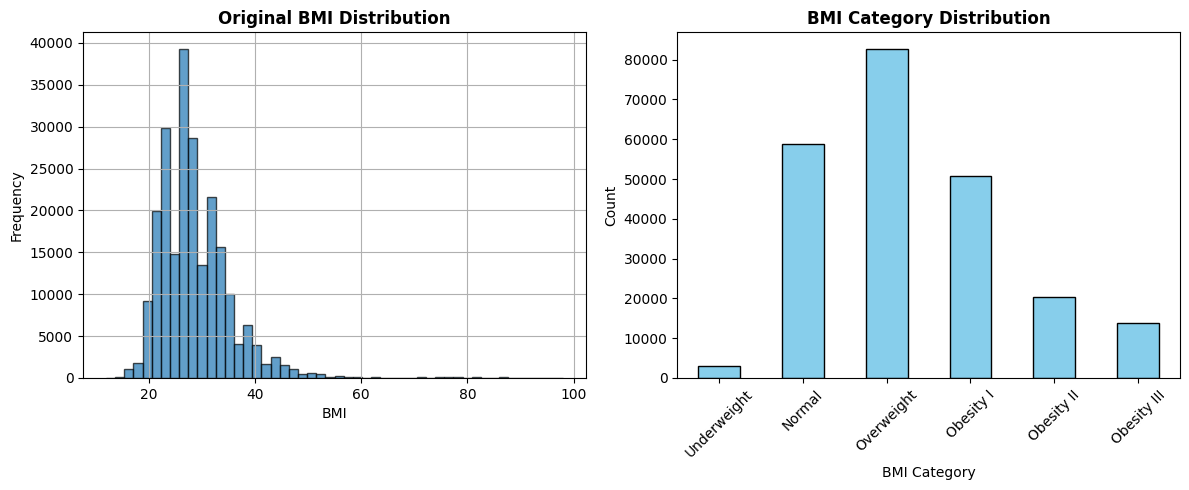


BMI Categories vs Diabetes Risk:
Diabetes_binary      0      1
bmi_category                 
0                94.46   5.54
1                93.36   6.64
2                87.23  12.77
3                79.89  20.11
4                72.35  27.65
5                66.41  33.59
['GenHlth', 'Age', 'Education', 'Income', 'bmi_category']
Scaled continuous features:
            MentHlth       PhysHlth
count  233252.000000  233252.000000
mean        1.294628       0.852740
std         2.759805       1.448567
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         1.000000       1.000000
max        10.000000       4.285714
Original continuous features:
            MentHlth       PhysHlth
count  229474.000000  229474.000000
mean        3.509866       4.681219
std         7.717643       9.050877
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         2.000000       4.00000

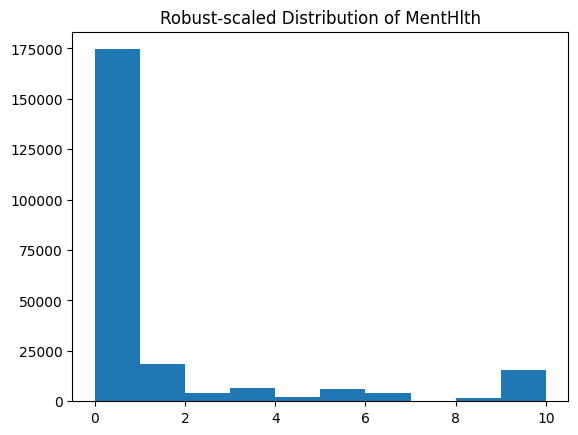

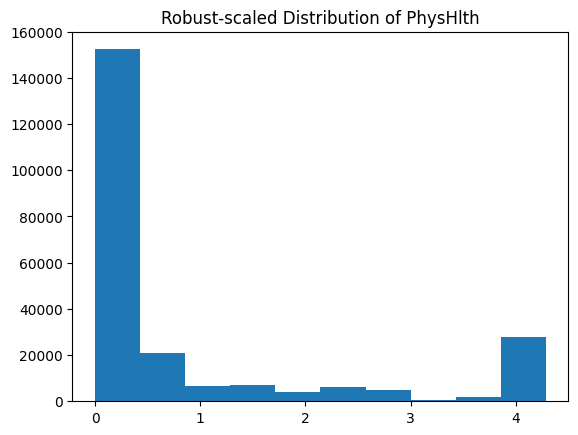

Train set class distribution:
Diabetes_binary
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation set class distribution:
Diabetes_binary
0    0.847042
1    0.152958
Name: proportion, dtype: float64

Test set class distribution:
Diabetes_binary
0    0.847064
1    0.152936
Name: proportion, dtype: float64
Features shape: torch.Size([64, 21])
Labels shape: torch.Size([64, 1])

Data loaded successfully from Week 2 notebook!
Training set: (233252, 21)
Validation set: (45895, 21)
Test set: (45895, 21)
Target distribution - Training: Diabetes_binary
1    0.5
0    0.5
Name: proportion, dtype: float64
Class imbalance ratio: 1.0:1
✅ All required variables loaded successfully!
   Available variables: ['X_train_scaled', 'X_val_scaled', 'X_test_scaled', 'y_train_resampled', 'y_val', 'y_test']


In [2]:
# Load data from Week 2 notebook
print("=== LOADING DATA FROM WEEK 2 ===")

# Import the variables from Week 2 notebook
%run -i gluco-track-week2-FeatureEngineering.ipynb

print(f"\nData loaded successfully from Week 2 notebook!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Target distribution - Training: {y_train_resampled.value_counts(normalize=True).round(4)}")
print(f"Class imbalance ratio: {y_train_resampled.value_counts(normalize=True)[0]/y_train_resampled.value_counts(normalize=True)[1]:.1f}:1")

# Verify that we have all the necessary variables
required_vars = ['X_train_scaled', 'X_val_scaled', 'X_test_scaled', 'y_train_resampled', 'y_val', 'y_test']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"⚠️  Missing variables: {missing_vars}")
    print("Please ensure Week 2 notebook has been run completely.")
else:
    print("✅ All required variables loaded successfully!")
    print(f"   Available variables: {required_vars}")

**For now, I will leave the FFNN model from Week 3 work in its current state to explore key features that may predict the diabetes outcome**

In [3]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)
        
model = FFNN(input_dim=X_train.shape[1])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [5]:
# Initialize the learning rate scheduler (choose conservative parameters)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', # Monitors a metric that should be minimized (e.g., loss)
    factor=0.5,
    patience=5 # Will reduce LR if the metric doesn't improve for 5 epochs
)
# ADD EARLY STOPPING VARIABLES HERE
patience_counter = 0
patience_limit = 5

# Start the MLflow run and log key parameters
with mlflow.start_run(run_name="baseline_ffnn2"):
    # Log model architecture and hyperparameters
    mlflow.log_params({
        "model_architecture": str(model),
        "batch_size": train_loader.batch_size,
        "initial_lr": optimizer.param_groups[0]['lr'],
        "lr_scheduler_patience": scheduler.patience,
        # Dynamically retrieve the dropout rate from the model's sequential layer
        # Assumes the first dropout layer is at index 3 of the `net` sequential module.
        "dropout_rate": model.net[3].p,
    })

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    best_val_f1 = 0.0
    best_val_loss = float('inf')

    n_epochs = 10
    for epoch in range(n_epochs):
        # Record the start time of the epoch
        start_time = time.time()

        # Training phase
        model.train()
        y_train_true, y_train_pred = [], []
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            # Unsqueeze the outputs to match the shape of y_batch for loss calculation
            outputs = outputs.unsqueeze(1) if outputs.dim() == 1 else outputs
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            y_train_true.extend(y_batch.cpu().numpy().flatten())
            y_train_pred.extend((outputs.cpu().detach().numpy().flatten() > 0.5).astype(int))
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_f1 = f1_score(y_train_true, y_train_pred)
        train_f1_scores.append(train_f1)
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_f1", train_f1, step=epoch)

        # Validation phase
        model.eval()
        y_val_true, y_val_pred, y_val_prob = [], [], []
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                # Unsqueeze the outputs to match the shape of y_batch for loss calculation
                outputs = outputs.unsqueeze(1) if outputs.dim() == 1 else outputs
                val_loss += criterion(outputs, y_batch).item()
                y_val_true.extend(y_batch.cpu().numpy().flatten())
                y_val_pred.extend((outputs.cpu().numpy().flatten() > 0.5).astype(int))
                y_val_prob.extend(outputs.cpu().numpy().flatten())
        
        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_f1 = f1_score(y_val_true, y_val_pred)

        # Log validation metrics
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        
        # Step the learning rate scheduler with the validation loss
        scheduler.step(val_loss)

        # ADD LEARNING RATE MONITORING
        current_lr = optimizer.param_groups[0]['lr']
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

        # ADD EARLY STOPPING CHECK
        if val_loss > best_val_loss:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"Early stopping at epoch {epoch+1} - validation loss hasn't improved for {patience_limit} epochs")
                break
        else:
            patience_counter = 0
            best_val_loss = val_loss

        print(f"Epoch {epoch+1}/{n_epochs}: Val F1: {val_f1:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

        # Log epoch training time
        end_time = time.time()
        epoch_duration = end_time - start_time
        mlflow.log_metric("epoch_time_seconds", epoch_duration, step=epoch)

        # Save the best model based on validation F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Save the model state dictionary
            torch.save(model.state_dict(), "best_model.pth")
            mlflow.log_artifact("best_model.pth")
            print(f"Epoch {epoch+1}/{n_epochs}: New best model saved with Val F1: {best_val_f1:.4f}")

    # Final evaluation on the test set
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # Unsqueeze the outputs to match the shape of y_batch for loss calculation
            outputs = outputs.unsqueeze(1) if outputs.dim() == 1 else outputs
            y_prob.extend(outputs.cpu().numpy().flatten())
            y_pred.extend((outputs.cpu().numpy().flatten() > 0.5).astype(int))
            y_true.extend(y_batch.cpu().numpy().flatten())

    # Calculate final test set metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    # Log final metrics to MLflow
    mlflow.log_metrics({
        "final_accuracy": acc, 
        "final_precision": prec, 
        "final_recall": rec, 
        "final_f1": f1, 
        "final_auc": auc
    })

    # Create and log Confusion Matrix as an artifact
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Create and log ROC Curve as an artifact
    plt.figure(figsize=(8, 6))
    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.title('ROC Curve')
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    # New code to plot F1 score curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_f1_scores, label='Training F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.savefig("f1_score_curves.png")
    mlflow.log_artifact("f1_score_curves.png")
    plt.close()

mlflow.end_run()

print(f"Final Test Metrics:")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

print("=== LOSS ANALYSIS ===")
print(f"Training loss range: {min(train_losses):.4f} - {max(train_losses):.4f}")
print(f"Validation loss range: {min(val_losses):.4f} - {max(val_losses):.4f}")
print(f"Training loss std: {np.std(train_losses):.4f}")
print(f"Validation loss std: {np.std(val_losses):.4f}")

# Check if losses are reasonable for binary classification
if train_losses[-1] > 0.7:
    print("⚠️ Training loss is high - model may not be learning effectively")
if val_losses[-1] > 0.7:
    print("⚠️ Validation loss is high - poor generalization")

Epoch 1/10: Val F1: 0.4258, Val Loss: 0.5506, LR: 0.000100
Epoch 1/10: New best model saved with Val F1: 0.4258
Epoch 2/10: Val F1: 0.4275, Val Loss: 0.5342, LR: 0.000100
Epoch 2/10: New best model saved with Val F1: 0.4275
Epoch 3/10: Val F1: 0.4233, Val Loss: 0.5505, LR: 0.000100
Epoch 4/10: Val F1: 0.4191, Val Loss: 0.5684, LR: 0.000100
Epoch 5/10: Val F1: 0.4258, Val Loss: 0.5363, LR: 0.000100
Epoch 6/10: Val F1: 0.4236, Val Loss: 0.5444, LR: 0.000100
Early stopping at epoch 7 - validation loss hasn't improved for 5 epochs
Final Test Metrics:
Accuracy: 0.690, Precision: 0.295, Recall: 0.739, F1: 0.422, AUC: 0.778
=== LOSS ANALYSIS ===
Training loss range: 0.5390 - 0.5799
Validation loss range: 0.5342 - 0.5684
Training loss std: 0.0135
Validation loss std: 0.0107


<Figure size 800x600 with 0 Axes>

**Feature importance using SHAP explainability tools:**

In [6]:
print("=== SHAP EXPLAINABILITY ANALYSIS ===")

# First, let's prepare the model for SHAP analysis
model.eval()  # Set model to evaluation mode

# Create a wrapper function for SHAP that handles the PyTorch model
def model_predict(X):
    """
    Wrapper function for SHAP that converts numpy arrays to PyTorch tensors
    and returns numpy predictions
    """
    model.eval()
    with torch.no_grad():
        # Convert to tensor and move to device
        X_tensor = torch.FloatTensor(X).to(device)
        # Get predictions
        outputs = model(X_tensor)
        # Return as numpy array
        return outputs.cpu().numpy().flatten()

# Prepare data for SHAP analysis
# Use a subset of training data as background for SHAP
background_size = 100
background_data = X_train_scaled.values[:background_size]

# Use a subset of test data for explanation
explain_size = 200
explain_data = X_test_scaled.values[:explain_size]

# Store feature names for later use
feature_names = X_train_scaled.columns.tolist()

print(f"Background data shape: {background_data.shape}")
print(f"Explanation data shape: {explain_data.shape}")

# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.Explainer(model_predict, background_data)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer(explain_data)

print("✅ SHAP analysis completed!")
print(f"SHAP values shape: {shap_values.values.shape}")

=== SHAP EXPLAINABILITY ANALYSIS ===
Background data shape: (100, 21)
Explanation data shape: (200, 21)
Initializing SHAP explainer...
Calculating SHAP values...
✅ SHAP analysis completed!
SHAP values shape: (200, 21)


Creating SHAP summary plot...


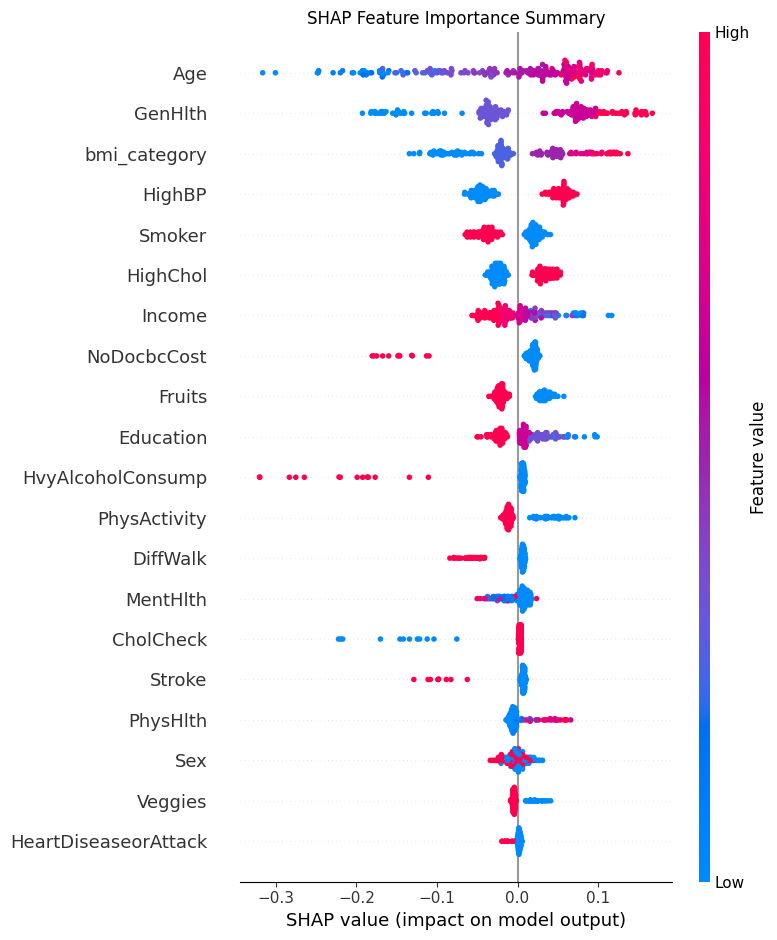

Creating SHAP bar plot...


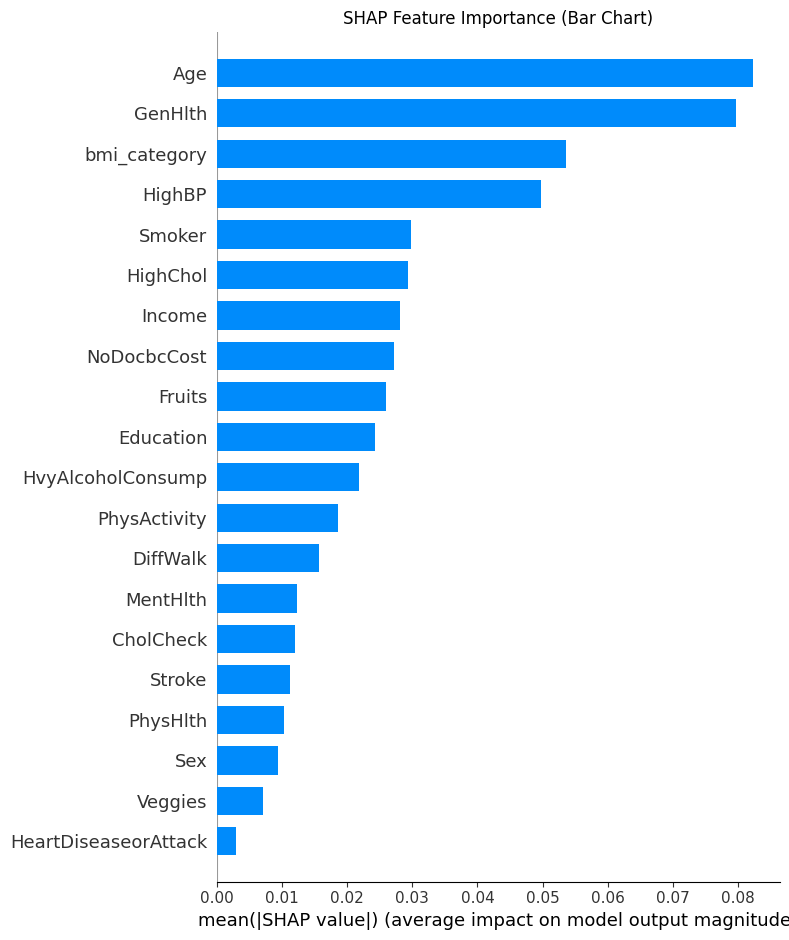

Creating SHAP waterfall plot for first prediction...


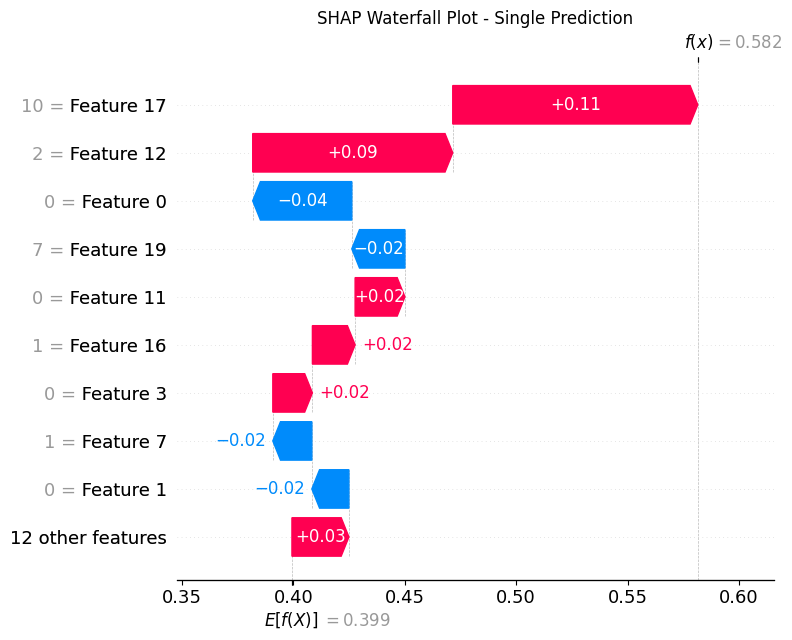

In [7]:
# === SHAP VISUALIZATIONS ===

# 1. Summary Plot (Feature Importance)
print("Creating SHAP summary plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values.values, explain_data, 
                  feature_names=feature_names,
                  show=False)
plt.title("SHAP Feature Importance Summary")
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Bar Plot (Mean absolute SHAP values)
print("Creating SHAP bar plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values.values, explain_data,
                  feature_names=feature_names,
                  plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Chart)")
plt.tight_layout()
plt.savefig("shap_bar_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Waterfall Plot for a single prediction
print("Creating SHAP waterfall plot for first prediction...")
plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_values[0], show=False)
plt.title("SHAP Waterfall Plot - Single Prediction")
plt.tight_layout()
plt.savefig("shap_waterfall_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Add this analysis after your SHAP plots:
print("=== INTERPRETING RED POINTS LEFT OF ZERO ===")

# Calculate feature correlations with SHAP values
for i, feature in enumerate(feature_names[:10]):  # Top 10 features
    feature_values = explain_data[:, i]
    feature_shap = shap_values.values[:, i]
    
    # Find instances where feature is high (red) and SHAP is negative (left of zero)
    high_values = feature_values > np.median(feature_values)
    negative_shap = feature_shap < 0
    red_left_pattern = high_values & negative_shap
    
    if red_left_pattern.sum() > 0:
        print(f"\n{feature}:")
        print(f"  High values reducing diabetes risk: {red_left_pattern.sum()} cases")
        print(f"  Average SHAP when feature is high: {feature_shap[high_values].mean():.3f}")
        print(f"  Clinical interpretation: Higher {feature} → Lower diabetes risk")

=== INTERPRETING RED POINTS LEFT OF ZERO ===

Smoker:
  High values reducing diabetes risk: 87 cases
  Average SHAP when feature is high: -0.041
  Clinical interpretation: Higher Smoker → Lower diabetes risk

Stroke:
  High values reducing diabetes risk: 9 cases
  Average SHAP when feature is high: -0.097
  Clinical interpretation: Higher Stroke → Lower diabetes risk

HeartDiseaseorAttack:
  High values reducing diabetes risk: 15 cases
  Average SHAP when feature is high: -0.011
  Clinical interpretation: Higher HeartDiseaseorAttack → Lower diabetes risk

HvyAlcoholConsump:
  High values reducing diabetes risk: 14 cases
  Average SHAP when feature is high: -0.221
  Clinical interpretation: Higher HvyAlcoholConsump → Lower diabetes risk


**The explanations of a few of the features above highlights that many risk factors we would expect to be potentially associated with diabetes risk are shown to be associated with lower risk.**

**However, the top features do make sense:  higher age and higher BMI are associated with higher diabetes risk.**

**General health makes sense once we revisit the scale: (higher values poorer)**
- Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

**While the higher values of smoker seem "protective" of diabetes risk, this is one of the questions I found to be problematic:**

- Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes. 

- Many people responding "yes" will have very different levels of health associations with smoking, depending on actual levels and whether smoking habits were in the past, recent, and continuous.**

**The NoDocBcCost is also a bit misleading.  It asks if there was a time in the past 12 months when patient needed to see a doctor but could not because of cost. There may have been resources for lower income patients to see a doctor.  There is no question regarding how often patients sought medical care in a single year.**



## **NEXT STEPS**

**I ran logistic regression and decision tree/ensemble models to compare the feature predictions. The top features were very similar for all except the regression model. Although the ensemble methods had slightly higher performance, I will create the Streamlit App based on the FFNN model here.**

In [9]:
print("=== SAVING MODEL COMPONENTS FOR STREAMLIT APP ===")

# 1. Save the trained model
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model state dict saved as 'best_model.pth'")

# 2. Create a COMPLETE preprocessing pipeline that matches your training process
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Define the continuous columns that need scaling
continuous_cols = ['MentHlth', 'PhysHlth']

# Create a preprocessing pipeline that handles all features
all_cols = X_train.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), continuous_cols),  # Scale only continuous features
        ('identity', 'passthrough', [col for col in all_cols if col not in continuous_cols])  # Keep other features as-is
    ]
)

# Fit the preprocessor on the original training data (before SMOTE)
preprocessor.fit(X_train)

# Save the complete preprocessor
import pickle
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("✅ Complete preprocessor saved as 'preprocessor.pkl'")

# 3. Save feature names (in the correct order after preprocessing)
# Get feature names after transformation
feature_names = (continuous_cols + 
                [col for col in X_train.columns if col not in continuous_cols])
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✅ Feature names saved as 'feature_names.pkl'")

# 4. Save model architecture parameters
model_config = {
    'input_size': len(X_train.columns),  # All features
    'hidden_size': 64,  # Update this to match your actual model
    'dropout_rate': model.net[3].p if hasattr(model.net[3], 'p') else 0.3,  # Extract from your model
    'output_size': 1
}
with open('model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print("✅ Model configuration saved as 'model_config.pkl'")

# 5. Save background data for SHAP (use properly preprocessed data)
background_sample = X_train_scaled.sample(n=100, random_state=42)
with open('shap_background.pkl', 'wb') as f:
    pickle.dump(background_sample.values, f)
print("✅ SHAP background data saved as 'shap_background.pkl'")

# 6. Save feature statistics for validation
feature_stats = {
    'means': X_train_scaled.mean().to_dict(),
    'stds': X_train_scaled.std().to_dict(),
    'mins': X_train_scaled.min().to_dict(),
    'maxs': X_train_scaled.max().to_dict()
}
with open('feature_stats.pkl', 'wb') as f:
    pickle.dump(feature_stats, f)
print("✅ Feature statistics saved as 'feature_stats.pkl'")

# 7. Test the complete pipeline
print("\n=== TESTING SAVED COMPONENTS ===")

# Test loading the model
test_model = FFNN(model_config['input_size'])
test_model.load_state_dict(torch.load("best_model.pth"))
test_model.eval()
print("✅ Model loading test passed")

# Test loading the preprocessor
with open('preprocessor.pkl', 'rb') as f:
    test_preprocessor = pickle.load(f)
print("✅ Preprocessor loading test passed")

# Test the complete pipeline with original unscaled data
sample_data = X_test.iloc[:1]  # Original unscaled test data
processed_data = test_preprocessor.transform(sample_data)

with torch.no_grad():
    test_tensor = torch.FloatTensor(processed_data)
    test_prediction = test_model(test_tensor)
    print(f"✅ Full pipeline test passed - sample prediction: {test_prediction.item():.4f}")

print("\n=== ALL COMPONENTS READY FOR STREAMLIT APP ===")
print("Files created:")
print("- best_model.pth")
print("- preprocessor.pkl (replaces scaler.pkl)")
print("- feature_names.pkl")
print("- model_config.pkl")
print("- shap_background.pkl")
print("- feature_stats.pkl")

print("\n🚀 Ready to deploy to Streamlit!")

=== SAVING MODEL COMPONENTS FOR STREAMLIT APP ===
✅ Model state dict saved as 'best_model.pth'
✅ Complete preprocessor saved as 'preprocessor.pkl'
✅ Feature names saved as 'feature_names.pkl'
✅ Model configuration saved as 'model_config.pkl'
✅ SHAP background data saved as 'shap_background.pkl'
✅ Feature statistics saved as 'feature_stats.pkl'

=== TESTING SAVED COMPONENTS ===
✅ Model loading test passed
✅ Preprocessor loading test passed
✅ Full pipeline test passed - sample prediction: 0.0130

=== ALL COMPONENTS READY FOR STREAMLIT APP ===
Files created:
- best_model.pth
- preprocessor.pkl (replaces scaler.pkl)
- feature_names.pkl
- model_config.pkl
- shap_background.pkl
- feature_stats.pkl

🚀 Ready to deploy to Streamlit!


In [11]:
print(model)

FFNN(
  (net): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [12]:
state_dict = torch.load("best_model.pth")
print(state_dict.keys())    

odict_keys(['net.0.weight', 'net.0.bias', 'net.1.weight', 'net.1.bias', 'net.1.running_mean', 'net.1.running_var', 'net.1.num_batches_tracked', 'net.4.weight', 'net.4.bias', 'net.5.weight', 'net.5.bias', 'net.5.running_mean', 'net.5.running_var', 'net.5.num_batches_tracked', 'net.8.weight', 'net.8.bias'])


In [13]:
import sklearn
print(sklearn.__file__)
print(sklearn.__version__)

c:\Users\novem\OneDrive\Documents\TheDen\Career\SuperDataScience\gluco_track\SDS-CP035-gluco-track\venv\Lib\site-packages\sklearn\__init__.py
1.7.1
